In [1]:
from pathlib import Path

import torch
from meningioma_dl.models.resnet import RESNET_MODELS_MAP, ResNet

device = torch.device("cuda")

def get_model(model_id:str):
    trained_model_path = Path("/home/cir/lsobocinski/data/meningioma/optuna/trials/models/",
                              model_id,
                              "epoch_-1.pth.tar"
                             )
    
    saved_model = torch.load(trained_model_path, map_location=device)
    no_cuda = False if device == torch.device("cuda") else True
    model = RESNET_MODELS_MAP[10](
        shortcut_type="B",
        no_cuda=no_cuda,
        num_classes=2,
    ).to(device)
    state_dict = {
        k.replace("module.", ""): v for k, v in saved_model["state_dict"].items()
    }
    model.load_state_dict(state_dict)
    return model

In [2]:
from meningioma_dl.data_loading.data_loader import (
    get_data_loader,
    TransformationsMode,
)
from meningioma_dl.experiments_specs.preprocessing_specs import PreprocessingSpecs

data_directory = Path("/home/cir/lsobocinski/data/meningioma/nifti")
labels_file = Path("/home/cir/lsobocinski/data/meningioma/ci_run_labels/test_labels.tsv")
class_mapping = {1: 1, 2: 2, 3: 2}

data_loader, labels = get_data_loader(
    labels_file,
    data_directory,
    transformations_mode=TransformationsMode.ONLY_PREPROCESSING,
    batch_size=1,
    preprocessing_specs=PreprocessingSpecs(),
    class_mapping=class_mapping,
)

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355087
Predicted label: 1, real label: 1


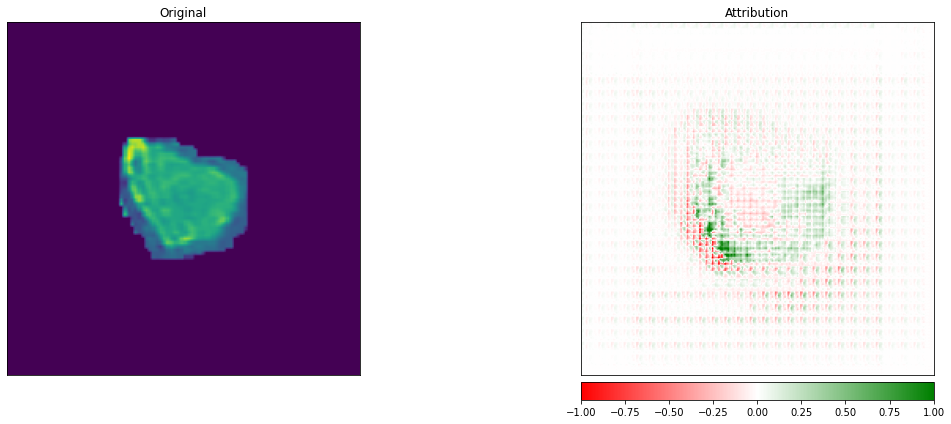

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355087
Predicted label: 1, real label: 0


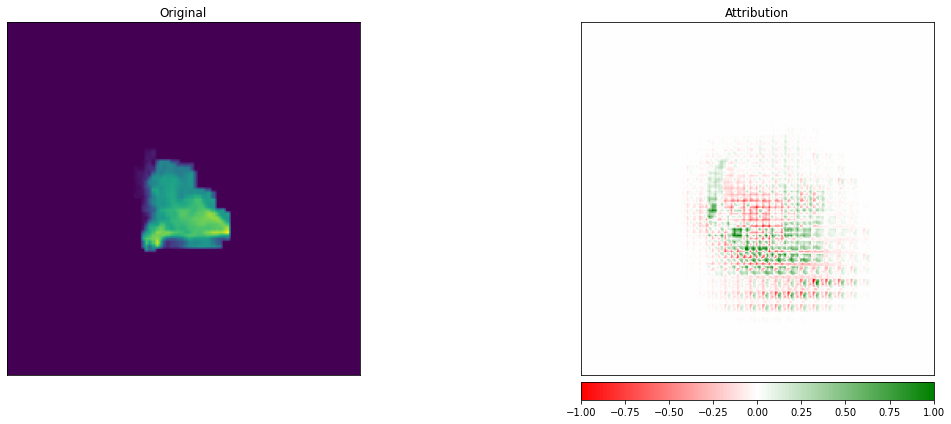

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355087
Predicted label: 1, real label: 1


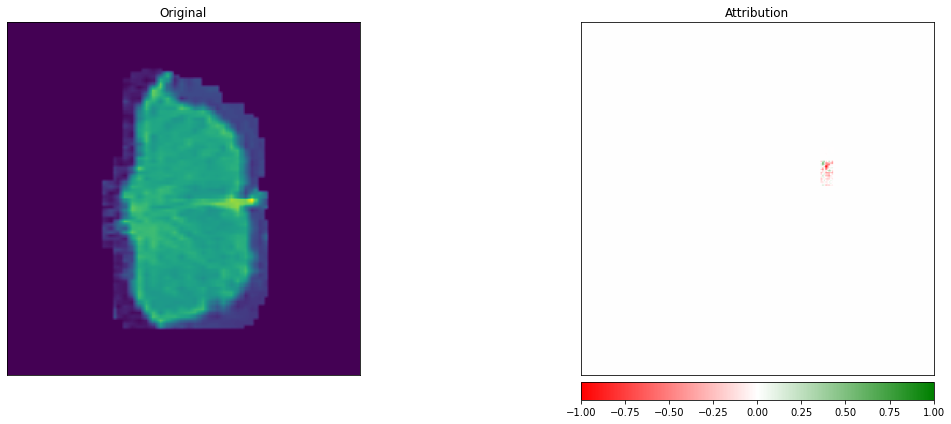

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355089
Predicted label: 1, real label: 1


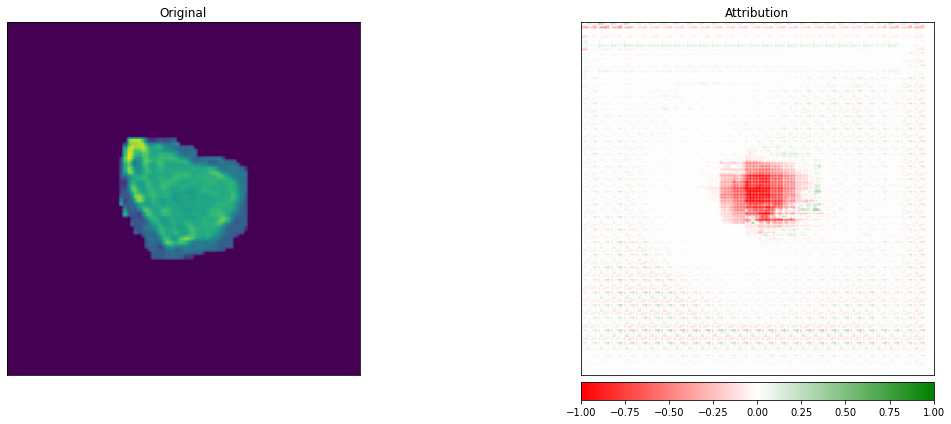

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355089
Predicted label: 1, real label: 0


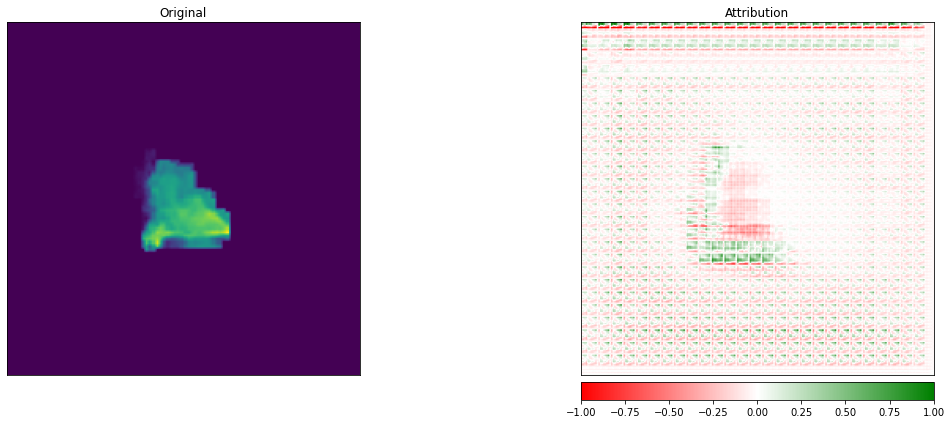

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355089
Predicted label: 1, real label: 1


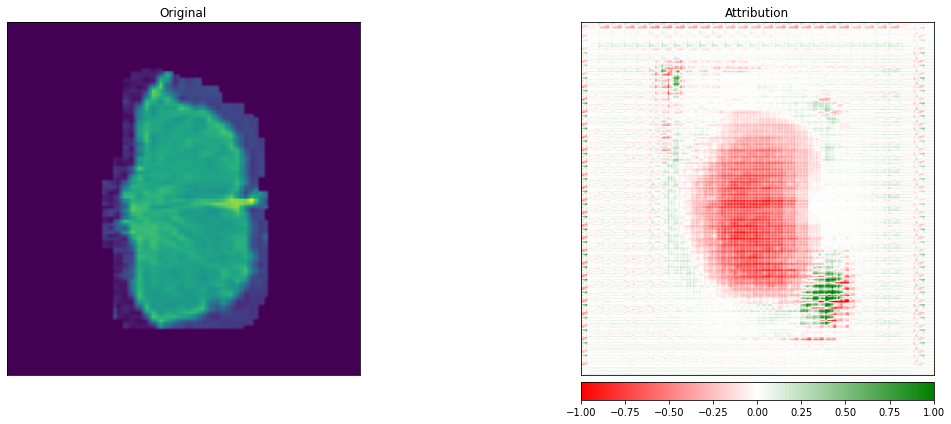

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355090
Predicted label: 1, real label: 0


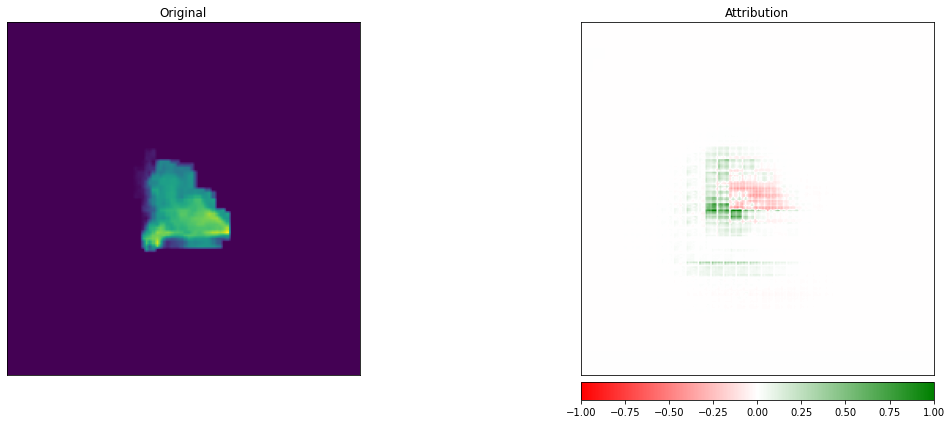

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355090
Predicted label: 1, real label: 1


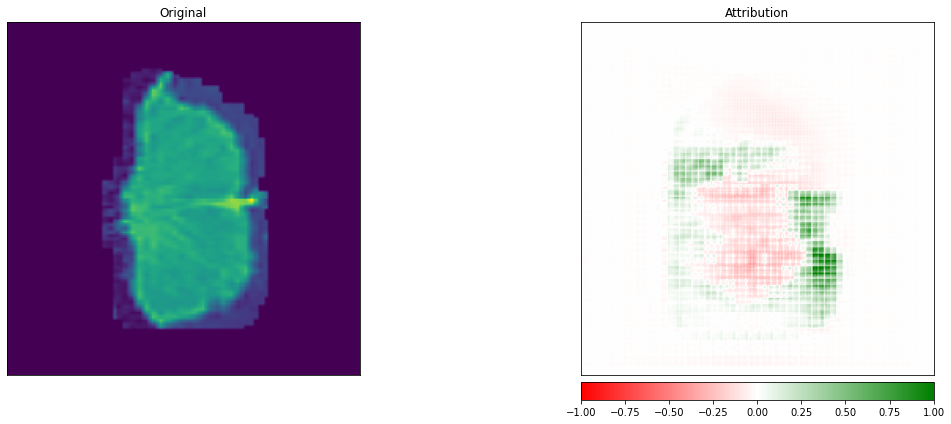

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355090
Predicted label: 1, real label: 1


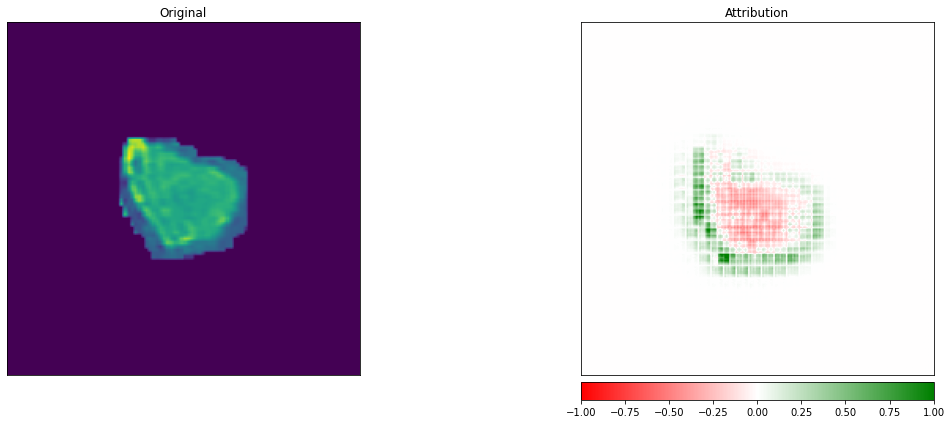

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355091
Predicted label: 1, real label: 0


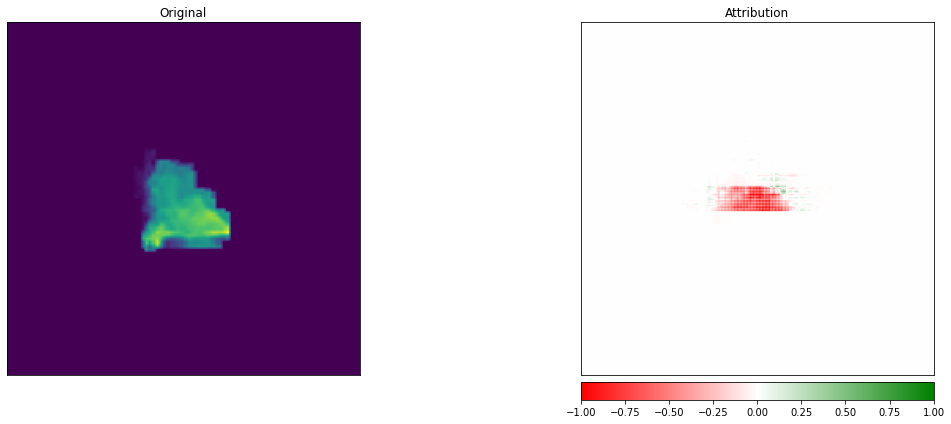

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355091
Predicted label: 1, real label: 1


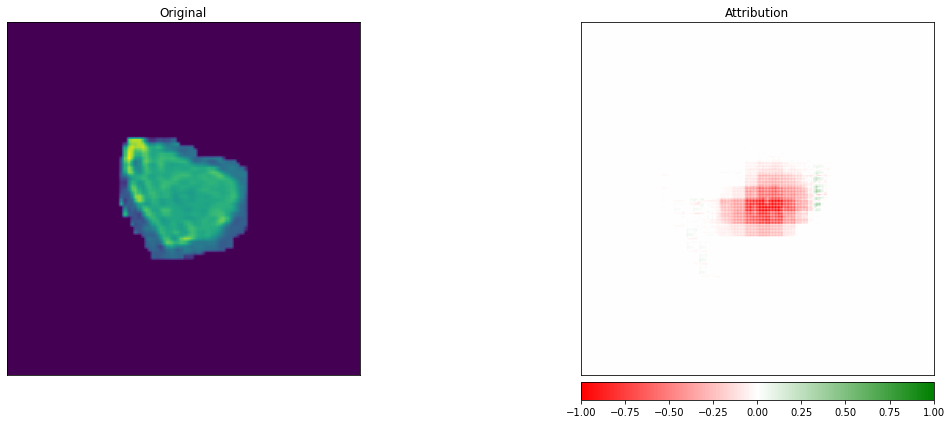

Run id: c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355091
Predicted label: 1, real label: 1


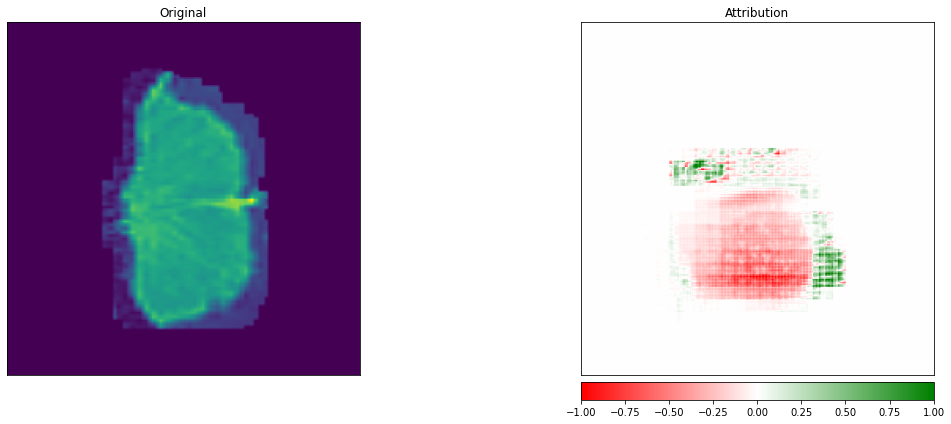

In [12]:
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

model_ids = [
    "c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355087",
    "c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355089",
    "c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355090",
    "c1_cross_validation_centralized_central_300_epochs_no_resize_strong_less_gaussian_08p_0001_lr_099_gamma_class_2_and_3_together_4_unfreezed_6355091",
]
for model_id in model_ids:
    model = get_model(model_id)
    loader = iter(data_loader)
    for i in range(3):
        img_data = next(loader)
        guided_gc = GuidedGradCam(model, model.layer3[0].conv2)
        # guided_gc = GuidedGradCam(model, model.conv1)
        label = model(img_data["img"].to(device)).argmax(dim=1)
        print(f"Run id: {model_id}")
        print(f"Predicted label: {label.item()}, real label: {img_data['label'].item()}")
        attribution = guided_gc.attribute(img_data["img"].to(device), target=label.to(device))
        viz.visualize_image_attr_multiple(
            # attribution[0, :, 122].cpu().permute(1,2,0).detach().numpy(),
            attribution[0].cpu().mean(axis=1).permute(1,2,0).detach().numpy(),
            img_data["img"][0, :, 123].permute(1,2,0).detach().numpy(),
            ["original_image","heat_map"], # blended_heat_map
            ["all","all"],
            show_colorbar=True,
            # cmap="gray",
            titles=["Original", "Attribution"],
            fig_size=(18, 6)
        )

In [11]:
label = model(img_data["img"].to(device)).argmax(dim=1)
label.item()

1

In [93]:
import numpy as np
np.unique(attribution[0].cpu().mean(axis=1).permute(1,2,0).detach().numpy())

array([0.], dtype=float32)

In [45]:
model


ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, 